## Sacrifice

This notebook takes in a dataset with predicted SVM labels and outputs an estimate of the cut sacrifice.

In [1]:
# Load modules

import json, glob, os
import math, lgdo
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib
from dspeed.vis.waveform_browser import WaveformBrowser

# Plot style 
plt.style.use('seaborn-v0_8-notebook')

# LGDO store
sto = lgdo.lh5.LH5Store()

Specify file paths and load DSP configuration file to look at waveforms further down.

In [52]:
category = 'saturation'
raw_file = f'../data/{category}_data_raw.h5'
dsp_file = f'../data/{category}_data_dsp.h5'

with open("../data/dsp_config_test.json", "r") as f:
    dsp_config = json.load(f)

Here we load parameters into NumPy arrays.

In [53]:
tb_dsp, _ = sto.read('detector/dsp', dsp_file)

energies = tb_dsp['energy'].nda
svm_labels = tb_dsp['svm_label'].nda

Define the machine learning data cleaning cut.

In [54]:
# Machine learning cut 
ml_dc_cut = (svm_labels == 0) | (svm_labels == 9)

energy_ml_cut = energies[ml_dc_cut]
energy_not_ml_cut = energies[~ml_dc_cut]

We then look at the energy spectrum before and after cuts.

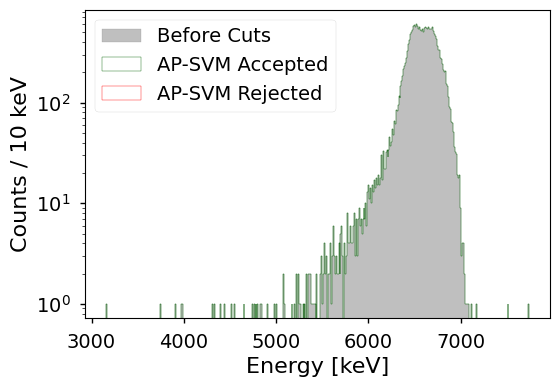

In [55]:
%matplotlib inline

binwidth = 10 # in keV units 
e_min, e_max = math.ceil(np.nanmin(energies)), math.ceil(np.nanmax(energies))
bins = range(e_min, e_max+binwidth, binwidth)

fig= plt.figure(figsize=(6,4))
ax = fig.add_subplot(111, axes_class=matplotlib.axes.Axes)

ax.hist(energies, bins=bins, fill=True, alpha= 0.5, color='grey',
        histtype='step', label =f'Before Cuts')
ax.hist(energy_ml_cut, bins=bins, color='darkgreen',
        label =f'AP-SVM Accepted', histtype='step')
ax.hist(energy_not_ml_cut, bins=bins, color='red',
        label =f'AP-SVM Rejected', histtype='step')

plt.xlabel('Energy [keV]', fontsize=16)
plt.ylabel(f'Counts / {binwidth} keV', fontsize=16)
plt.yscale('log')
plt.gca().tick_params(axis='x', labelsize=14) 
plt.gca().tick_params(axis='y', labelsize=14) 
plt.legend(loc='best', fontsize=14, fancybox=True)

file_format='pdf'
plt.savefig(f"../plots/sacrifice_{category}_energy.{file_format}", format=file_format,
            dpi='figure', bbox_inches='tight')

Define clopper pearson confidence intervals.

In [56]:
import scipy, math

def clopper_pearson(x, n, alpha=0.05):
    """Estimate the confidence interval for a sampled Bernoulli random
    variable.
    `x` is the number of successes and `n` is the number trials (x <=
    n). `alpha` is the confidence level (i.e., the true probability is
    inside the confidence interval with probability 1-alpha). The
    function returns a `(low, high)` pair of numbers indicating the
    interval on the probability.
    """
    b = scipy.stats.beta.ppf
    lo = b(alpha / 2, x, n - x + 1)
    hi = b(1 - alpha / 2, x + 1, n - x)
    return 0.0 if math.isnan(lo) else lo, 1.0 if math.isnan(hi) else hi

Calculate sacrifice with 90 % confidence intervals.

In [57]:
n_pass, n_tot = energy_ml_cut.shape[0], energies.shape[0]
n_cut = n_tot - n_pass

s_lo, s_hi = clopper_pearson(n_cut, n_tot, alpha=0.10)

s_lo_pct, s_hi_pct = s_lo*100, s_hi*100

sacrifice = n_cut/n_tot*100

print(f"Total = {n_tot}")
print(f"Pass = {n_pass}")
print(f"Fail = {n_cut}")
print(f"Sacrifice = {sacrifice} + {s_hi_pct - sacrifice} - {sacrifice - s_lo_pct}")

Total = 23659
Pass = 23659
Fail = 0
Sacrifice = 0.0 + 0.0126613238931005 - 0.0


We now look at waveforms that are accepted by this data cleaning method using the WaveformBrowser class.

In [58]:
entries = np.where(ml_dc_cut)[0]
n_wfs = len(entries) if len(entries) <= 10 else 10

wfb = WaveformBrowser(files_in = raw_file,
                      dsp_config = dsp_config,
                      lines = ['wf_norm'],
                      lh5_group = 'detector/raw',
                      x_unit = 'us',
                      buffer_len = 1,
                      n_drawn = n_wfs)

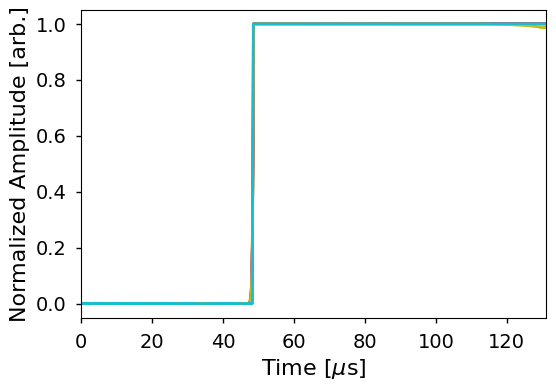

In [59]:
%matplotlib inline

fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(111, axes_class=matplotlib.axes.Axes)

wfb.set_figure(fig=fig, ax=ax)
wfb.draw_entry(entries[0:n_wfs])

plt.xlabel(r'Time [$\mu$s]', fontsize=16)
plt.ylabel('Normalized Amplitude [arb.]', fontsize=16)
plt.gca().tick_params(axis='x', labelsize=14) 
plt.gca().tick_params(axis='y', labelsize=14) 

file_format='pdf'
plt.savefig(f"../plots/sacrifice_{category}_accepted_wfs.{file_format}", format=file_format,
            dpi='figure', bbox_inches='tight')

Finally, we look at waveforms that are rejected by this data cleaning method using the WaveformBrowser class.

In [60]:
entries = np.where(~ml_dc_cut)[0]
n_wfs = len(entries) if len(entries) <= 10 else 10

wfb = WaveformBrowser(files_in = raw_file,
                      dsp_config = dsp_config,
                      lines = ['wf_norm'],
                      lh5_group = 'detector/raw',
                      x_unit = 'us',
                      buffer_len = 1,
                      n_drawn = n_wfs)

In [65]:
%matplotlib inline

if n_wfs == 0:
    print("No rejected waveforms.")
    
else:

    fig = plt.figure(figsize=(6,4))
    ax = fig.add_subplot(111, axes_class=matplotlib.axes.Axes)

    wfb.set_figure(fig=fig, ax=ax)
    wfb.draw_entry(entries[0:n_wfs])

    plt.xlabel(r'Time [$\mu$s]', fontsize=16)
    plt.ylabel('Normalized Amplitude [arb.]', fontsize=16)
    plt.gca().tick_params(axis='x', labelsize=14) 
    plt.gca().tick_params(axis='y', labelsize=14) 

    file_format='pdf'
    plt.savefig(f"../plots/sacrifice_{category}_rejected_wfs.{file_format}", format=file_format,
                dpi='figure', bbox_inches='tight')

No rejected waveforms.
